In [1]:
reset -fs

In [2]:
import pandas as pd
import numpy as np
from datetime import datetime 

import geopandas
import matplotlib.pyplot as plt
import folium

from shapely.geometry import Point, Polygon
from pyproj import CRS

import re

In [3]:
# Load daily weather data from all stations in US, Canada and Mexico

df = pd.read_csv('LCD_2021/subset/daily.csv')

/Users/noether/miniforge3/envs/eclipse/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3251: DtypeWarning: Columns (0,5,6,7,8,9,10,11,13,14,15,16,17,18,19,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [4]:
# Rename columns

df.rename(columns={'HourlyAltimeterSetting': 'ALTSE',
                   'HourlyDewPointTemperature': 'DP',
                   'HourlyDryBulbTemperature': 'TEMP',
                   'HourlyPrecipitation': 'PCP',
                   'HourlyPresentWeatherType': 'WTH',
                   'HourlyPressureChange': 'P_CHG',
                   'HourlyPressureTendency': 'P_TEND',
                   'HourlyRelativeHumidity': 'RH',
                   'HourlySkyConditions': 'SKY',
                   'HourlySeaLevelPressure': 'SLP',
                   'HourlyStationPressure': 'STP',
                   'HourlyVisibility': 'VIS',
                   'HourlyWetBulbTemperature': 'WB_TEMP',
                   'HourlyWindDirection': 'WIND_DIR',
                   'HourlyWindGustSpeed': 'GUST',
                   'HourlyWindSpeed': 'WIND',}, inplace=True)

In [5]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

In [6]:
# Check that there aren't too many empty 'SKY' entries to do decent analysis
df['SKY'].isnull().sum()

31086567

In [7]:
# drop all rows without the 'SKY' entry
df_sky = df[df['SKY'].notnull()]

In [8]:
df.groupby(['STATION'])['SKY'].count()

STATION
69015093121     8549
70000126492    13126
70019726558    10843
70026027502    15675
70030027503     9877
               ...  
A0735500241    24089
A0735700182    23053
A0735900240    25238
A5125500445    25105
A5125600451    25175
Name: SKY, Length: 3519, dtype: int64

In [9]:
df_sky.shape

(33503655, 22)

In [10]:
# min_dataset = df_sky[df_sky.groupby(['STATION'])['SKY'].transform('size')>= 8760]
# min_dataset.shape

In [24]:
# count number of unique stations with a SKY variable
df_sky.STATION.nunique()

2657

In [25]:
stations_list = df_sky.groupby(['STATION']).first()
stations_list.shape

(2657, 21)

In [13]:
# Load geopandas dataframe from stations_list to plot stations

geo_stations_full = geopandas.GeoDataFrame(
    stations_list, crs = CRS("WGS84"), geometry = geopandas.points_from_xy(stations_list.LONGITUDE, stations_list.LATITUDE))

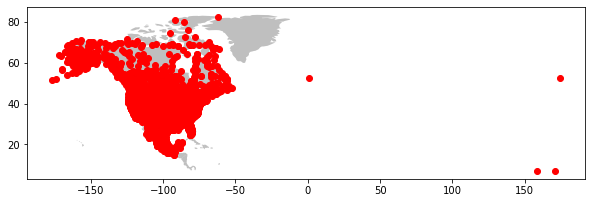

In [14]:
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))

# We restrict to North America.
fig, ax = plt.subplots(figsize=(10, 10))
world[world.continent == 'North America'].plot(
    color='grey', alpha = 0.5, ax=ax)

geo_stations_full.plot(ax=ax, color='red')
plt.show()

In [15]:
# Identify outliers
high_lon = stations_list['LONGITUDE'][stations_list['LONGITUDE'].astype(float) > 0]
high_lon

STATION
70414045715    174.10000
74900599999      1.16200
99999940504    158.21670
99999940710    171.27203
Name: LONGITUDE, dtype: float64

In [16]:
# Drop those outlier stations
geo_stations_clean = geo_stations_full[(geo_stations_full.LONGITUDE <= 0)].reset_index()

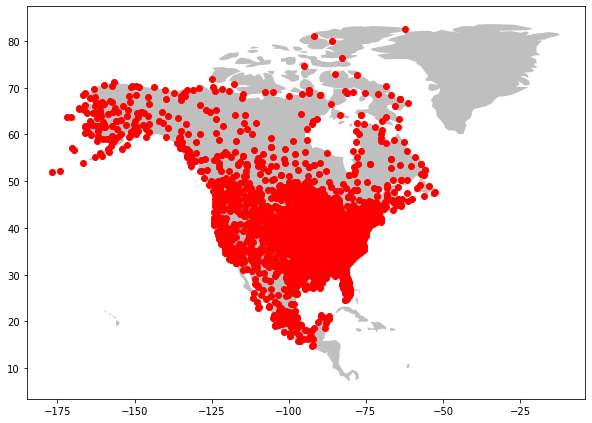

In [17]:
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))

# We restrict to North America.
fig, ax = plt.subplots(figsize=(10, 10))
world[world.continent == 'North America'].plot(
    color='grey', alpha = 0.5, ax=ax)

geo_stations_clean.plot(ax=ax, color='red')
plt.show()

In [18]:
stations_json = geo_stations_clean.to_json()

In [19]:
# # Folium map
# map = folium.Map(location = [40,-100], tiles = "Stamen Terrain", zoom_start = 4)
# points = folium.features.GeoJson(stations_json)
# map.add_child(points)
# map

In [20]:
# Now I want to restrict the dataset to only those stations that fall within the solar eclipse path: 

# Loading solar eclipse path

eclipse_path = pd.read_csv('eclipse_path/solar_eclipse_2024_04_08.csv')

# convert UTC to datetime
eclipse_path['UTC'] = pd.to_datetime('2024-04-08 ' + eclipse_path['UTC'], format='%Y-%m-%d %H:%M')


#function to convert DDM (degree decimal minutes) to decimal degrees

import re

def ddm_to_dec(ddm_str): 
    sign = -1 if re.search('[swSW]', ddm_str) else 1
    numbers = [*filter(len, re.split('\D+', ddm_str))]
    degree = numbers[0]
    minute_decimal = numbers[1] 
    decimal_val = numbers[2] if len(numbers) > 2 else '0' 
    minute_decimal += "." + decimal_val

    return sign * (int(degree) + float(minute_decimal) / 60)



eclipse_path.loc[:,'NLAT':'CLON'] = eclipse_path.loc[:,'NLAT':'CLON'].applymap(ddm_to_dec)

## Map the path using folium

lat_point_list = []
lon_point_list = []

lat_point_list.extend(eclipse_path['NLAT'].tolist())
lat_point_list.extend(eclipse_path['SLAT'].values[::-1].tolist())
lat_point_list.append(eclipse_path['NLAT'].iloc[0].tolist())

lon_point_list.extend(eclipse_path['NLON'].tolist())
lon_point_list.extend(eclipse_path['SLON'].values[::-1].tolist())
lon_point_list.append(eclipse_path['NLON'].iloc[0].tolist())

path_geom = Polygon(zip(lon_point_list, lat_point_list))
crs = CRS("WGS84")
path = geopandas.GeoDataFrame(index=[0], crs=crs, geometry=[path_geom])       
print(path.geometry)

path.to_file(filename='path.geojson', driver='GeoJSON')
#polygon.to_file(filename='path.shp', driver="ESRI Shapefile")

path_map = folium.Map([39.0119, -98.4842], zoom_start=4, tiles='cartodbpositron')

folium.GeoJson(path).add_to(path_map)
folium.LatLngPopup().add_to(path_map)
#path_map

0    POLYGON ((-149.79333 -5.51000, -145.49333 -4.3...
Name: geometry, dtype: geometry


In [21]:
# Restrict stations to only those in the path
pts_in_path = geopandas.sjoin(geo_stations_clean, path, predicate='within', how='inner').drop(['index_right'], axis=1)
pts_in_path.shape

(198, 23)

In [22]:
subset_json = pts_in_path.to_json()

In [23]:
# View stations
subset_map = folium.Map([39.0119, -98.4842], zoom_start=4, tiles='cartodbpositron')
points = folium.features.GeoJson(subset_json)
subset_map.add_child(points)
folium.GeoJson(path).add_to(subset_map)
folium.LatLngPopup().add_to(subset_map)
subset_map

In [69]:
pts_in_path['geometry'].to_csv('eclipse_path_stations_list.csv')

In [72]:
# Now that we have our eclipse path station list, limit the clean station dataset to those stations in the 
# eclipse path

path_obs = df_sky[df_sky['STATION'].isin(pts_in_path['STATION'])]

path_obs.head()

,STATION,DATE,LATITUDE,LONGITUDE,ELEVATION,NAME,ALTSE,DP,TEMP,PCP,WTH,P_CHG,P_TEND,RH,SKY,SLP,STP,VIS,WB_TEMP,WIND_DIR,GUST,WIND
4257715,71262599999,2021-01-01T17:31:00,43.191666,-79.171667,97.84,"NIAGARA DISTRICT, CA",30.08,28,32,NaN,NaN,NaN,NaN,87.0,7.0,30.10,NaN,0.5,NaN,080,NaN,10.0
4258011,71262599999,2021-01-18T16:02:00,43.191666,-79.171667,97.84,"NIAGARA DISTRICT, CA",29.81,28,32,NaN,NaN,NaN,NaN,87.0,4.0,29.82,NaN,1.0,NaN,000,NaN,0.0
4258017,71262599999,2021-01-18T17:13:00,43.191666,-79.171667,97.84,"NIAGARA DISTRICT, CA",29.84,30,32,NaN,||SHSN,NaN,NaN,93.0,6.0,29.85,NaN,1.5,NaN,VRB,NaN,3.0
4258256,71262599999,2021-02-01T10:47:00,43.191666,-79.171667,97.84,"NIAGARA DISTRICT, CA",30.07,21,25,NaN,NaN,NaN,NaN,86.0,9.0,30.09,NaN,1.0,NaN,050,24.0,18.0
4258330,71262599999,2021-02-05T15:48:00,43.191666,-79.171667,97.84,"NIAGARA DISTRICT, CA",29.60,18,25,NaN,||SHSN,NaN,NaN,74.0,7.0,29.62,NaN,1.5,NaN,240,33.0,23.0


In [74]:
# create geopandas dataframe of eclipse path observations
geo_path_obs = geopandas.GeoDataFrame(df_sky[df_sky['STATION'].isin(pts_in_path['STATION'])], 
                                  crs = CRS("WGS84"),
                                  geometry = geopandas.points_from_xy(
                                               path_obs.LONGITUDE, path_obs.LATITUDE))
geo_path_obs.shape

(2783032, 23)

In [75]:
# get growing zone variable from USDA data
usda_zones = geopandas.read_file('eclipse_path/ophz-b-wgs84.geojson')

In [77]:
usda = geopandas.sjoin(geo_path_obs, usda_zones, predicate='within', how='inner').drop(['index_right'], axis=1).reset_index()
usda.shape

(2727803, 27)

In [78]:
usda.head()

,index,STATION,DATE,LATITUDE,LONGITUDE,ELEVATION,NAME,ALTSE,DP,TEMP,PCP,WTH,P_CHG,P_TEND,RH,SKY,SLP,STP,VIS,WB_TEMP,WIND_DIR,GUST,WIND,geometry,OBJECTID,temp,zone
0,11234512,72011053983,2021-01-01T00:15:00,30.78361,-98.66194,335.9,"LLANO MUNICIPAL AIRPORT, TX US",29.78,30,34,NaN,NaN,NaN,NaN,87.0,FEW:02 15 SCT:04 22 OVC:08 26,NaN,28.61,10.00,32.0,280,NaN,15.0,POINT (-98.66194 30.78361),24891,10,8a
1,11234513,72011053983,2021-01-01T00:35:00,30.78361,-98.66194,335.9,"LLANO MUNICIPAL AIRPORT, TX US",29.8,30,34,NaN,NaN,NaN,NaN,87.0,BKN:07 15 OVC:08 27,NaN,28.63,10.00,32.0,270,21,14.0,POINT (-98.66194 30.78361),24891,10,8a
2,11234514,72011053983,2021-01-01T00:55:00,30.78361,-98.66194,335.9,"LLANO MUNICIPAL AIRPORT, TX US",29.81,30,34,NaN,NaN,NaN,NaN,87.0,BKN:07 13 BKN:07 18 OVC:08 29,NaN,28.64,10.00,32.0,270,20,14.0,POINT (-98.66194 30.78361),24891,10,8a
3,11234515,72011053983,2021-01-01T01:15:00,30.78361,-98.66194,335.9,"LLANO MUNICIPAL AIRPORT, TX US",29.81,30,34,NaN,NaN,NaN,NaN,87.0,BKN:07 14 OVC:08 19,NaN,28.64,10.00,32.0,270,NaN,14.0,POINT (-98.66194 30.78361),24891,10,8a
4,11234516,72011053983,2021-01-01T01:35:00,30.78361,-98.66194,335.9,"LLANO MUNICIPAL AIRPORT, TX US",29.8,30,34,NaN,NaN,NaN,NaN,87.0,BKN:07 15 OVC:08 20,NaN,28.63,10.00,32.0,270,NaN,13.0,POINT (-98.66194 30.78361),24891,10,8a


In [79]:
# This is pretty unbalanced, this may not be a good variable
usda.groupby(['zone'])['STATION'].nunique()

zone
3b     1
4a     6
4b     7
5a     5
5b     8
6a    46
6b    20
7a     9
7b    12
8a    43
8b    16
9a     5
Name: STATION, dtype: int64

In [80]:
zoned_path_obs = usda.drop(['index','WTH','OBJECTID','temp'], axis=1)
zoned_path_obs.head()

,STATION,DATE,LATITUDE,LONGITUDE,ELEVATION,NAME,ALTSE,DP,TEMP,PCP,P_CHG,P_TEND,RH,SKY,SLP,STP,VIS,WB_TEMP,WIND_DIR,GUST,WIND,geometry,zone
0,72011053983,2021-01-01T00:15:00,30.78361,-98.66194,335.9,"LLANO MUNICIPAL AIRPORT, TX US",29.78,30,34,NaN,NaN,NaN,87.0,FEW:02 15 SCT:04 22 OVC:08 26,NaN,28.61,10.00,32.0,280,NaN,15.0,POINT (-98.66194 30.78361),8a
1,72011053983,2021-01-01T00:35:00,30.78361,-98.66194,335.9,"LLANO MUNICIPAL AIRPORT, TX US",29.8,30,34,NaN,NaN,NaN,87.0,BKN:07 15 OVC:08 27,NaN,28.63,10.00,32.0,270,21,14.0,POINT (-98.66194 30.78361),8a
2,72011053983,2021-01-01T00:55:00,30.78361,-98.66194,335.9,"LLANO MUNICIPAL AIRPORT, TX US",29.81,30,34,NaN,NaN,NaN,87.0,BKN:07 13 BKN:07 18 OVC:08 29,NaN,28.64,10.00,32.0,270,20,14.0,POINT (-98.66194 30.78361),8a
3,72011053983,2021-01-01T01:15:00,30.78361,-98.66194,335.9,"LLANO MUNICIPAL AIRPORT, TX US",29.81,30,34,NaN,NaN,NaN,87.0,BKN:07 14 OVC:08 19,NaN,28.64,10.00,32.0,270,NaN,14.0,POINT (-98.66194 30.78361),8a
4,72011053983,2021-01-01T01:35:00,30.78361,-98.66194,335.9,"LLANO MUNICIPAL AIRPORT, TX US",29.8,30,34,NaN,NaN,NaN,87.0,BKN:07 15 OVC:08 20,NaN,28.63,10.00,32.0,270,NaN,13.0,POINT (-98.66194 30.78361),8a


In [82]:
# Cleaning up nan values for precipitation
zoned_path_obs['PCP'] = zoned_path_obs['PCP'].fillna(0)
zoned_path_obs = zoned_path_obs.drop(['P_CHG','P_TEND','SLP','GUST'], axis=1)

In [83]:
# Convert date column to datetime
zoned_path_obs['DATE'] = zoned_path_obs['DATE'].str.replace('T',' ')
zoned_path_obs['DATE'] = pd.to_datetime(zoned_path_obs['DATE'])
zoned_path_obs['DATE']

In [86]:
# Create season (month) variable
zoned_path_obs['MONTH'] = zoned_path_obs['DATE'].dt.month

In [87]:
# Create boolean for clear sky observation
zoned_path_obs['CLEAR'] = zoned_path_obs['SKY'].str.contains('CLR:00', 1)
zoned_path_obs[zoned_path_obs['CLEAR']==True]

,STATION,DATE,LATITUDE,LONGITUDE,ELEVATION,NAME,ALTSE,DP,TEMP,PCP,RH,SKY,STP,VIS,WB_TEMP,WIND_DIR,WIND,geometry,zone,MONTH,CLEAR
40,72011053983,2021-01-01 13:35:00,30.78361,-98.66194,335.9,"LLANO MUNICIPAL AIRPORT, TX US",30.04,32,48,0,54.0,CLR:00,28.86,10.00,41.0,310,11.0,POINT (-98.66194 30.78361),8a,1,True
42,72011053983,2021-01-01 14:15:00,30.78361,-98.66194,335.9,"LLANO MUNICIPAL AIRPORT, TX US",30.05,32,48,0,54.0,CLR:00,28.87,10.00,41.0,300,16.0,POINT (-98.66194 30.78361),8a,1,True
43,72011053983,2021-01-01 14:35:00,30.78361,-98.66194,335.9,"LLANO MUNICIPAL AIRPORT, TX US",30.05,32,50,0,50.0,CLR:00,28.87,10.00,42.0,310,14.0,POINT (-98.66194 30.78361),8a,1,True
44,72011053983,2021-01-01 14:55:00,30.78361,-98.66194,335.9,"LLANO MUNICIPAL AIRPORT, TX US",30.05,32,50,0,50.0,CLR:00,28.87,10.00,42.0,320,14.0,POINT (-98.66194 30.78361),8a,1,True
45,72011053983,2021-01-01 15:15:00,30.78361,-98.66194,335.9,"LLANO MUNICIPAL AIRPORT, TX US",30.05,32,50,0,50.0,CLR:00,28.87,10.00,42.0,320,10.0,POINT (-98.66194 30.78361),8a,1,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2727571,72712014607,2021-12-27 17:54:00,46.87049,-68.01723,188.6,"CARIBOU WEATHER FORECAST OFFICE, ME US",29.95,6,13,0.00,74.0,CLR:00,29.28,10.00,11.0,310,5.0,POINT (-68.01723 46.87049),4b,12,True
2727572,72712014607,2021-12-27 18:54:00,46.87049,-68.01723,188.6,"CARIBOU WEATHER FORECAST OFFICE, ME US",29.93,7,14,0.00,73.0,CLR:00,29.26,10.00,12.0,010,5.0,POINT (-68.01723 46.87049),4b,12,True
2727573,72712014607,2021-12-27 19:54:00,46.87049,-68.01723,188.6,"CARIBOU WEATHER FORECAST OFFICE, ME US",29.92,5,11,0.00,77.0,CLR:00,29.25,10.00,10.0,310,7.0,POINT (-68.01723 46.87049),4b,12,True
2727574,72712014607,2021-12-27 20:54:00,46.87049,-68.01723,188.6,"CARIBOU WEATHER FORECAST OFFICE, ME US",29.92,6,11,0.00,81.0,CLR:00,29.25,10.00,10.0,350,6.0,POINT (-68.01723 46.87049),4b,12,True


### Various data cleanup issues

In [88]:
zoned_path_obs.groupby(['STATION'])['CLEAR'].sum().astype(int)

STATION
72011053983     8889
72017063851     6711
72017253996    13013
72028653977    15838
72029153970     8829
               ...  
74740013973     5273
74907799999        0
99999900447     6127
99999993816    13766
A0708600468     9992
Name: CLEAR, Length: 178, dtype: int64

In [89]:
zoned_path_obs = zoned_path_obs.dropna().reset_index()
zoned_path_obs = zoned_path_obs.drop(['index'], axis = 1)
zoned_path_obs.shape

(2614234, 21)

In [92]:
zoned_path_obs['ALTSE'].astype('string')
zoned_path_obs['DP'].astype('string')
zoned_path_obs['TEMP'].astype('string')
zoned_path_obs['PCP'].astype('string')
zoned_path_obs['RH'].astype('string')
zoned_path_obs['STP'].astype('string')
zoned_path_obs['VIS'].astype('string')
zoned_path_obs['WB_TEMP'].astype('string')
zoned_path_obs['WIND_DIR'].astype('string')
zoned_path_obs['WIND'].astype('string')

0          15.0
1          14.0
2          14.0
3          14.0
4          13.0
           ... 
2614229     6.0
2614230     6.0
2614231     6.0
2614232     6.0
2614233     8.0
Name: WIND, Length: 2614234, dtype: string

In [93]:
zoned_path_obs['ALTSE'] = zoned_path_obs['ALTSE'].astype(str).str.replace(r'[^0-9.]+','')
zoned_path_obs['DP'] = zoned_path_obs['DP'].astype(str).str.replace(r'[^0-9.]+','')
zoned_path_obs['TEMP'] = zoned_path_obs['TEMP'].astype(str).str.replace(r'[^0-9.]+','')
zoned_path_obs['PCP'] = zoned_path_obs['PCP'].astype(str).str.replace(r'[^0-9.]+','')
zoned_path_obs['RH'] = zoned_path_obs['RH'].astype(str).str.replace(r'[^0-9.]+','')
zoned_path_obs['STP'] = zoned_path_obs['STP'].astype(str).str.replace(r'[^0-9.]+','')
zoned_path_obs['VIS'] = zoned_path_obs['VIS'].astype(str).str.replace(r'[^0-9.]+','')
zoned_path_obs['WB_TEMP'] = zoned_path_obs['WB_TEMP'].astype(str).str.replace(r'[^0-9.]+','')
zoned_path_obs['WIND_DIR'] = zoned_path_obs['WIND_DIR'].astype(str).str.replace(r'[^0-9.]+','')
zoned_path_obs['WIND'] = zoned_path_obs['WIND'].astype(str).str.replace(r'[^0-9.]+','')

/var/folders/_g/0w700wks7s1f9mzvhbcn7vvc0000gn/T/ipykernel_13570/150355791.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  zoned_path_obs['ALTSE'] = zoned_path_obs['ALTSE'].astype(str).str.replace(r'[^0-9.]+','')
/var/folders/_g/0w700wks7s1f9mzvhbcn7vvc0000gn/T/ipykernel_13570/150355791.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  zoned_path_obs['DP'] = zoned_path_obs['DP'].astype(str).str.replace(r'[^0-9.]+','')
/var/folders/_g/0w700wks7s1f9mzvhbcn7vvc0000gn/T/ipykernel_13570/150355791.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  zoned_path_obs['TEMP'] = zoned_path_obs['TEMP'].astype(str).str.replace(r'[^0-9.]+','')
/var/folders/_g/0w700wks7s1f9mzvhbcn7vvc0000gn/T/ipykernel_13570/150355791.py:4: FutureWarning: The default value of regex will change from True to False in a future version.
  zoned_path_obs['PCP'] = zoned_

In [94]:
zoned_path_obs['ALTSE']

0          29.78
1           29.8
2          29.81
3          29.81
4           29.8
           ...  
2614229    29.94
2614230    29.94
2614231    29.93
2614232    29.93
2614233    29.93
Name: ALTSE, Length: 2614234, dtype: object

In [95]:
zoned_path_obs[zoned_path_obs['PCP'].str.count('\.').ge(2)]

,STATION,DATE,LATITUDE,LONGITUDE,ELEVATION,NAME,ALTSE,DP,TEMP,PCP,RH,SKY,STP,VIS,WB_TEMP,WIND_DIR,WIND,geometry,zone,MONTH,CLEAR
1191546,72429093815,2021-02-15 17:56:00,39.90638,-84.21853,302.6,"DAYTON INTERNATIONAL AIRPORT, OH US",29.87,11,17,0.050.07,77,VV:09 14,28.80,0.50,15,030,22,POINT (-84.21853 39.90638),6a,2,False
1191557,72429093815,2021-02-15 21:56:00,39.90638,-84.21853,302.6,"DAYTON INTERNATIONAL AIRPORT, OH US",29.73,11,17,0.010.09,77,VV:09 10,28.66,0.50,15,360,15,POINT (-84.21853 39.90638),6a,2,False


In [96]:
zoned_path_obs[(zoned_path_obs['STATION'] == 72429093815) & (zoned_path_obs.DATE.astype(str).str.contains('2021-02-15'))]

,STATION,DATE,LATITUDE,LONGITUDE,ELEVATION,NAME,ALTSE,DP,TEMP,PCP,RH,SKY,STP,VIS,WB_TEMP,WIND_DIR,WIND,geometry,zone,MONTH,CLEAR
1191508,72429093815,2021-02-15 00:56:00,39.90638,-84.21853,302.6,"DAYTON INTERNATIONAL AIRPORT, OH US",30.26,8,19,0.00,62,SCT:04 27 OVC:08 35,29.18,10.00,16,010,14,POINT (-84.21853 39.90638),6a,2,False
1191509,72429093815,2021-02-15 01:56:00,39.90638,-84.21853,302.6,"DAYTON INTERNATIONAL AIRPORT, OH US",30.26,7,18,0.00,62,FEW:02 27 BKN:07 32 OVC:08 41,29.18,10.00,15,010,13,POINT (-84.21853 39.90638),6a,2,False
1191510,72429093815,2021-02-15 02:56:00,39.90638,-84.21853,302.6,"DAYTON INTERNATIONAL AIRPORT, OH US",30.25,8,18,0.00,65,BKN:07 38 OVC:08 45,29.17,10.00,15,360,11,POINT (-84.21853 39.90638),6a,2,False
1191511,72429093815,2021-02-15 03:54:00,39.90638,-84.21853,302.6,"DAYTON INTERNATIONAL AIRPORT, OH US",30.25,9,18,,68,OVC:08 25,29.17,1.75,16,010,13,POINT (-84.21853 39.90638),6a,2,False
1191512,72429093815,2021-02-15 03:56:00,39.90638,-84.21853,302.6,"DAYTON INTERNATIONAL AIRPORT, OH US",30.25,8,17,0.01,68,SCT:04 15 OVC:08 25,29.17,1.50,15,010,14,POINT (-84.21853 39.90638),6a,2,False
1191513,72429093815,2021-02-15 04:42:00,39.90638,-84.21853,302.6,"DAYTON INTERNATIONAL AIRPORT, OH US",30.23,9,16,0.02,74,OVC:08 32,29.15,2.00,14,010,14,POINT (-84.21853 39.90638),6a,2,False
1191514,72429093815,2021-02-15 04:56:00,39.90638,-84.21853,302.6,"DAYTON INTERNATIONAL AIRPORT, OH US",30.22,9,16,0.03,74,BKN:07 31 OVC:08 40,29.14,2.00,14,010,14,POINT (-84.21853 39.90638),6a,2,False
1191515,72429093815,2021-02-15 05:16:00,39.90638,-84.21853,302.6,"DAYTON INTERNATIONAL AIRPORT, OH US",30.23,9,16,,74,VV:09 20,29.15,1.00,14,010,13,POINT (-84.21853 39.90638),6a,2,False
1191516,72429093815,2021-02-15 05:32:00,39.90638,-84.21853,302.6,"DAYTON INTERNATIONAL AIRPORT, OH US",30.22,9,15,0.02,77,VV:09 13,29.14,1.00,13,010,15,POINT (-84.21853 39.90638),6a,2,False
1191517,72429093815,2021-02-15 05:45:00,39.90638,-84.21853,302.6,"DAYTON INTERNATIONAL AIRPORT, OH US",30.23,9,15,0.02,77,OVC:08 15,29.15,1.50,13,360,13,POINT (-84.21853 39.90638),6a,2,False


In [97]:
zoned_path_obs_dropped = zoned_path_obs.drop([1191546, 1191557]).reset_index(drop=True)
zoned_path_obs_dropped

,STATION,DATE,LATITUDE,LONGITUDE,ELEVATION,NAME,ALTSE,DP,TEMP,PCP,RH,SKY,STP,VIS,WB_TEMP,WIND_DIR,WIND,geometry,zone,MONTH,CLEAR
0,72011053983,2021-01-01 00:15:00,30.78361,-98.66194,335.9,"LLANO MUNICIPAL AIRPORT, TX US",29.78,30,34,0,87.0,FEW:02 15 SCT:04 22 OVC:08 26,28.61,10.00,32.0,280,15.0,POINT (-98.66194 30.78361),8a,1,False
1,72011053983,2021-01-01 00:35:00,30.78361,-98.66194,335.9,"LLANO MUNICIPAL AIRPORT, TX US",29.8,30,34,0,87.0,BKN:07 15 OVC:08 27,28.63,10.00,32.0,270,14.0,POINT (-98.66194 30.78361),8a,1,False
2,72011053983,2021-01-01 00:55:00,30.78361,-98.66194,335.9,"LLANO MUNICIPAL AIRPORT, TX US",29.81,30,34,0,87.0,BKN:07 13 BKN:07 18 OVC:08 29,28.64,10.00,32.0,270,14.0,POINT (-98.66194 30.78361),8a,1,False
3,72011053983,2021-01-01 01:15:00,30.78361,-98.66194,335.9,"LLANO MUNICIPAL AIRPORT, TX US",29.81,30,34,0,87.0,BKN:07 14 OVC:08 19,28.64,10.00,32.0,270,14.0,POINT (-98.66194 30.78361),8a,1,False
4,72011053983,2021-01-01 01:35:00,30.78361,-98.66194,335.9,"LLANO MUNICIPAL AIRPORT, TX US",29.8,30,34,0,87.0,BKN:07 15 OVC:08 20,28.63,10.00,32.0,270,13.0,POINT (-98.66194 30.78361),8a,1,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2614227,72712014607,2021-12-31 21:44:00,46.87049,-68.01723,188.6,"CARIBOU WEATHER FORECAST OFFICE, ME US",29.94,28,32,0,85.0,BKN:07 9 OVC:08 20,29.27,10.00,30.0,160,6.0,POINT (-68.01723 46.87049),4b,12,False
2614228,72712014607,2021-12-31 21:54:00,46.87049,-68.01723,188.6,"CARIBOU WEATHER FORECAST OFFICE, ME US",29.94,28,32,0.00,85.0,BKN:07 9 OVC:08 20,29.27,10.00,30.0,160,6.0,POINT (-68.01723 46.87049),4b,12,False
2614229,72712014607,2021-12-31 22:00:00,46.87049,-68.01723,188.6,"CARIBOU WEATHER FORECAST OFFICE, ME US",29.93,28,32,0,85.0,8,29.27,9.94,30.0,160,6.0,POINT (-68.01723 46.87049),4b,12,False
2614230,72712014607,2021-12-31 22:54:00,46.87049,-68.01723,188.6,"CARIBOU WEATHER FORECAST OFFICE, ME US",29.93,28,31,,89.0,OVC:08 7,29.26,10.00,30.0,170,6.0,POINT (-68.01723 46.87049),4b,12,False


In [98]:
zoned_path_obs_dropped['PCP'].str.strip()

# zoned_path_obs_fix = zoned_path_obs_dropped.loc['STATION':'CLEAR'].astype('string').strip()

zoned_path_obs_fix = zoned_path_obs_dropped
zoned_path_obs_fix

,STATION,DATE,LATITUDE,LONGITUDE,ELEVATION,NAME,ALTSE,DP,TEMP,PCP,RH,SKY,STP,VIS,WB_TEMP,WIND_DIR,WIND,geometry,zone,MONTH,CLEAR
0,72011053983,2021-01-01 00:15:00,30.78361,-98.66194,335.9,"LLANO MUNICIPAL AIRPORT, TX US",29.78,30,34,0,87.0,FEW:02 15 SCT:04 22 OVC:08 26,28.61,10.00,32.0,280,15.0,POINT (-98.66194 30.78361),8a,1,False
1,72011053983,2021-01-01 00:35:00,30.78361,-98.66194,335.9,"LLANO MUNICIPAL AIRPORT, TX US",29.8,30,34,0,87.0,BKN:07 15 OVC:08 27,28.63,10.00,32.0,270,14.0,POINT (-98.66194 30.78361),8a,1,False
2,72011053983,2021-01-01 00:55:00,30.78361,-98.66194,335.9,"LLANO MUNICIPAL AIRPORT, TX US",29.81,30,34,0,87.0,BKN:07 13 BKN:07 18 OVC:08 29,28.64,10.00,32.0,270,14.0,POINT (-98.66194 30.78361),8a,1,False
3,72011053983,2021-01-01 01:15:00,30.78361,-98.66194,335.9,"LLANO MUNICIPAL AIRPORT, TX US",29.81,30,34,0,87.0,BKN:07 14 OVC:08 19,28.64,10.00,32.0,270,14.0,POINT (-98.66194 30.78361),8a,1,False
4,72011053983,2021-01-01 01:35:00,30.78361,-98.66194,335.9,"LLANO MUNICIPAL AIRPORT, TX US",29.8,30,34,0,87.0,BKN:07 15 OVC:08 20,28.63,10.00,32.0,270,13.0,POINT (-98.66194 30.78361),8a,1,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2614227,72712014607,2021-12-31 21:44:00,46.87049,-68.01723,188.6,"CARIBOU WEATHER FORECAST OFFICE, ME US",29.94,28,32,0,85.0,BKN:07 9 OVC:08 20,29.27,10.00,30.0,160,6.0,POINT (-68.01723 46.87049),4b,12,False
2614228,72712014607,2021-12-31 21:54:00,46.87049,-68.01723,188.6,"CARIBOU WEATHER FORECAST OFFICE, ME US",29.94,28,32,0.00,85.0,BKN:07 9 OVC:08 20,29.27,10.00,30.0,160,6.0,POINT (-68.01723 46.87049),4b,12,False
2614229,72712014607,2021-12-31 22:00:00,46.87049,-68.01723,188.6,"CARIBOU WEATHER FORECAST OFFICE, ME US",29.93,28,32,0,85.0,8,29.27,9.94,30.0,160,6.0,POINT (-68.01723 46.87049),4b,12,False
2614230,72712014607,2021-12-31 22:54:00,46.87049,-68.01723,188.6,"CARIBOU WEATHER FORECAST OFFICE, ME US",29.93,28,31,,89.0,OVC:08 7,29.26,10.00,30.0,170,6.0,POINT (-68.01723 46.87049),4b,12,False


In [99]:
zoned_path_obs_fix.loc[:,'LATITUDE':'ELEVATION'] = zoned_path_obs_fix.loc[:,'LATITUDE':'ELEVATION'].apply(pd.to_numeric, errors='coerce').fillna(0)
zoned_path_obs_fix.loc[:,'ALTSE':'RH'] = zoned_path_obs_fix.loc[:,'ALTSE':'RH'].apply(pd.to_numeric, errors='coerce').fillna(0)
zoned_path_obs_fix.loc[:,'STP':'WIND'] = zoned_path_obs_fix.loc[:,'STP':'WIND'].apply(pd.to_numeric, errors='coerce').fillna(0)

zoned_path_obs_fix.dtypes

STATION              object
DATE         datetime64[ns]
LATITUDE            float64
LONGITUDE           float64
ELEVATION           float64
NAME                 object
ALTSE               float64
DP                  float64
TEMP                float64
PCP                 float64
RH                  float64
SKY                  object
STP                 float64
VIS                 float64
WB_TEMP             float64
WIND_DIR            float64
WIND                float64
geometry           geometry
zone                 object
MONTH                 int64
CLEAR                object
dtype: object

In [100]:
zoned_path_obs_fix = zoned_path_obs_fix.rename(columns={'zone':'ZONE'})
zoned_path_obs_fix.columns

Index(['STATION', 'DATE', 'LATITUDE', 'LONGITUDE', 'ELEVATION', 'NAME',
       'ALTSE', 'DP', 'TEMP', 'PCP', 'RH', 'SKY', 'STP', 'VIS', 'WB_TEMP',
       'WIND_DIR', 'WIND', 'geometry', 'ZONE', 'MONTH', 'CLEAR'],
      dtype='object')

In [101]:
#cols = zoned_path_obs_fix.columns.tolist()

cols = (['STATION','NAME','geometry','DATE','SKY',
         'LATITUDE','LONGITUDE','ELEVATION','ALTSE',
         'DP','TEMP','PCP','RH','STP','VIS','WB_TEMP',
         'WIND_DIR','WIND','ZONE','MONTH','CLEAR'])

zoned_path_obs_fix = zoned_path_obs_fix[cols]
zoned_path_obs_fix

,STATION,NAME,geometry,DATE,SKY,LATITUDE,LONGITUDE,ELEVATION,ALTSE,DP,TEMP,PCP,RH,STP,VIS,WB_TEMP,WIND_DIR,WIND,ZONE,MONTH,CLEAR
0,72011053983,"LLANO MUNICIPAL AIRPORT, TX US",POINT (-98.66194 30.78361),2021-01-01 00:15:00,FEW:02 15 SCT:04 22 OVC:08 26,30.78361,-98.66194,335.9,29.78,30.0,34.0,0.0,87.0,28.61,10.00,32.0,280.0,15.0,8a,1,False
1,72011053983,"LLANO MUNICIPAL AIRPORT, TX US",POINT (-98.66194 30.78361),2021-01-01 00:35:00,BKN:07 15 OVC:08 27,30.78361,-98.66194,335.9,29.80,30.0,34.0,0.0,87.0,28.63,10.00,32.0,270.0,14.0,8a,1,False
2,72011053983,"LLANO MUNICIPAL AIRPORT, TX US",POINT (-98.66194 30.78361),2021-01-01 00:55:00,BKN:07 13 BKN:07 18 OVC:08 29,30.78361,-98.66194,335.9,29.81,30.0,34.0,0.0,87.0,28.64,10.00,32.0,270.0,14.0,8a,1,False
3,72011053983,"LLANO MUNICIPAL AIRPORT, TX US",POINT (-98.66194 30.78361),2021-01-01 01:15:00,BKN:07 14 OVC:08 19,30.78361,-98.66194,335.9,29.81,30.0,34.0,0.0,87.0,28.64,10.00,32.0,270.0,14.0,8a,1,False
4,72011053983,"LLANO MUNICIPAL AIRPORT, TX US",POINT (-98.66194 30.78361),2021-01-01 01:35:00,BKN:07 15 OVC:08 20,30.78361,-98.66194,335.9,29.80,30.0,34.0,0.0,87.0,28.63,10.00,32.0,270.0,13.0,8a,1,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2614227,72712014607,"CARIBOU WEATHER FORECAST OFFICE, ME US",POINT (-68.01723 46.87049),2021-12-31 21:44:00,BKN:07 9 OVC:08 20,46.87049,-68.01723,188.6,29.94,28.0,32.0,0.0,85.0,29.27,10.00,30.0,160.0,6.0,4b,12,False
2614228,72712014607,"CARIBOU WEATHER FORECAST OFFICE, ME US",POINT (-68.01723 46.87049),2021-12-31 21:54:00,BKN:07 9 OVC:08 20,46.87049,-68.01723,188.6,29.94,28.0,32.0,0.0,85.0,29.27,10.00,30.0,160.0,6.0,4b,12,False
2614229,72712014607,"CARIBOU WEATHER FORECAST OFFICE, ME US",POINT (-68.01723 46.87049),2021-12-31 22:00:00,8,46.87049,-68.01723,188.6,29.93,28.0,32.0,0.0,85.0,29.27,9.94,30.0,160.0,6.0,4b,12,False
2614230,72712014607,"CARIBOU WEATHER FORECAST OFFICE, ME US",POINT (-68.01723 46.87049),2021-12-31 22:54:00,OVC:08 7,46.87049,-68.01723,188.6,29.93,28.0,31.0,0.0,89.0,29.26,10.00,30.0,170.0,6.0,4b,12,False


In [103]:
zoned_path_obs_fix.to_csv('path_obs_clean_2021.csv', index=False)